In [3]:
pip install textblob

   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
   ---------------------------------------- 624.3/624.3 kB 4.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


1. Завантаження даних...
Завантажено/очищено: 999 рядків.
Завантаження ресурсів NLTK...
2. Підготовка даних...
Препроцесинг завершено.
3. Sentiment аналіз (polarity, subjectivity)...
Sentiment аналіз завершено.
4. Візуалізація polarity та subjectivity по категоріях...


C:\Users\Asus\AppData\Local\Temp\ipykernel_37056\3193615925.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='score', y='p', data=df, palette='viridis'); plt.title('Polarity'); plt.xlabel('Score'); plt.ylabel('Polarity')
C:\Users\Asus\AppData\Local\Temp\ipykernel_37056\3193615925.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='score', y='s', data=df, palette='viridis'); plt.title('Subjectivity'); plt.xlabel('Score'); plt.ylabel('Subjectivity')


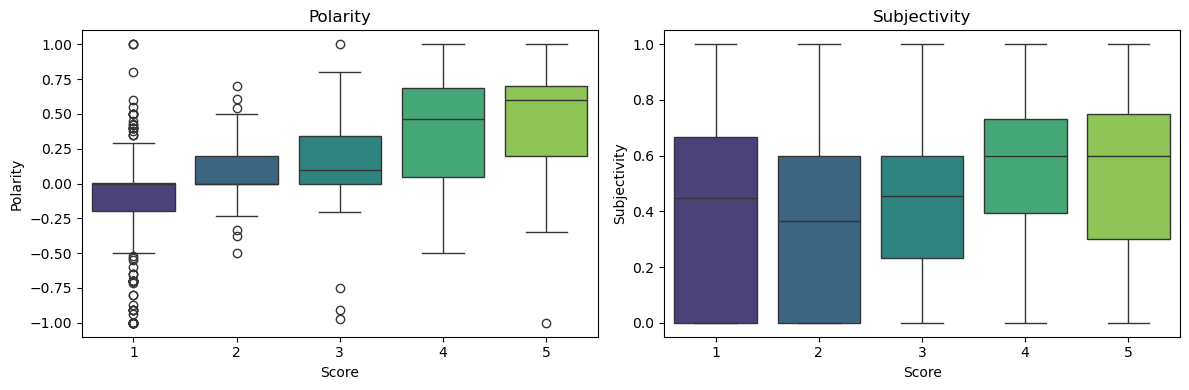

5. Оцінка якості: середня полярність по класах...

Середня полярність:
score
1   -0.099184
2    0.064625
3    0.126915
4    0.399879
5    0.491879
Name: p, dtype: float64
Зв'язок монотонний.
6. Визначення іменників у текстах...
Виділення іменників завершено.
7. Тематичне моделювання (LDA)...
Документів для LDA: 792
Розмір словника LDA: 399
Навчання LDA...

5 тем (по 7 слів):
Тема 1: phone | movie | season | brightness | dont | option | play
Тема 2: money | pay | payment | cost | use | subscription | login
Тема 3: app | movie | watch | series | download | doesnt | work
Тема 4: love | absolute | israel | bias | experience | episode | movie
Тема 5: movie | account | content | time | quality | watch | video


In [9]:
import pandas as pd, numpy as np, re, nltk, matplotlib.pyplot as plt, seaborn as sns, warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

DATA_PATH = "reviews.csv"
MAX_ROWS, N_TOPICS, N_WORDS = 1000, 5, 7

# 1. Завантаження необхідних даних
print("1. Завантаження даних...")
try:
    df = pd.read_csv(DATA_PATH, usecols=['content', 'score'], nrows=MAX_ROWS).dropna(subset=['content'])
    df['score'] = pd.to_numeric(df['score'], errors='coerce')
    df = df.dropna(subset=['score']).astype({'score': int})
    print(f"Завантажено/очищено: {len(df)} рядків.")
except Exception as e: exit(f"Помилка завантаження: {e}")

# Ресурси NLTK
resources = ['wordnet', 'punkt', 'stopwords', 'averaged_perceptron_tagger', 'averaged_perceptron_tagger_eng']
try:
    for r in resources: nltk.data.find(f"{'corpora' if '/' not in r else 'taggers'}/{r.replace('_eng','')}")
    if 'averaged_perceptron_tagger_eng' not in nltk.data.find('taggers/averaged_perceptron_tagger_eng'): raise LookupError()
except LookupError:
    print("Завантаження ресурсів NLTK...")
    try: [nltk.download(r.split('/')[-1], quiet=True) for r in resources]
    except Exception as e: exit(f"Помилка завантаження NLTK: {e}")

# 2. Підготовка даних
print("2. Підготовка даних...")
stop_w = set(stopwords.words('english')) | {"service"}
lemmatizer = WordNetLemmatizer()
def preprocess(txt):
    try:
        txt = re.sub(r'[^a-z\s]', '', str(txt).lower())
        return [lemmatizer.lemmatize(w) for w in word_tokenize(txt) if w not in stop_w and len(w) > 2]
    except: return []
df['tokens'] = df['content'].apply(preprocess)
print("Препроцесинг завершено.")

# 3. Оцінка polarity та subjectivity
print("3. Sentiment аналіз (polarity, subjectivity)...")
df[['p', 's']] = df['content'].apply(lambda txt: pd.Series(TextBlob(str(txt)).sentiment) if isinstance(txt, str) else pd.Series([np.nan, np.nan]))
df.dropna(subset=['p', 's'], inplace=True)
print("Sentiment аналіз завершено.")

# 4. Візуалізація sentiment результатів
print("4. Візуалізація polarity та subjectivity по категоріях...")
plt.figure(figsize=(12, 4)); plt.subplot(1, 2, 1)
sns.boxplot(x='score', y='p', data=df, palette='viridis'); plt.title('Polarity'); plt.xlabel('Score'); plt.ylabel('Polarity')
plt.subplot(1, 2, 2)
sns.boxplot(x='score', y='s', data=df, palette='viridis'); plt.title('Subjectivity'); plt.xlabel('Score'); plt.ylabel('Subjectivity')
plt.tight_layout(); plt.show()

# 5. Оцінка якості аналізу
print("5. Оцінка якості: середня полярність по класах...")
avg_p = df.groupby('score')['p'].mean()
print(f"\nСередня полярність:\n{avg_p}\nЗв'язок {'монотонний' if avg_p.is_monotonic_increasing else 'не монотонний'}.")

# 6. Визначення іменників
print("6. Визначення іменників у текстах...")
def get_nouns(tkns):
    try: return [w for w, tag in nltk.pos_tag(tkns) if tag.startswith('N')]
    except: return []
df['nouns'] = df['tokens'].apply(get_nouns)
print("Виділення іменників завершено.")

# 7. Тематичне моделювання LDA
print("7. Тематичне моделювання (LDA)...")
topic_corp = df[df['nouns'].apply(len) > 0]['nouns'].apply(' '.join).tolist()
if not topic_corp:
    print("Помилка: Немає даних для LDA.")
else:
    print(f"Документів для LDA: {len(topic_corp)}")
    try:
        vzer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
        dtm = vzer.fit_transform(topic_corp)
        f_names = vzer.get_feature_names_out()
        print(f"Розмір словника LDA: {len(f_names)}")
        lda = LatentDirichletAllocation(n_components=N_TOPICS, random_state=42, learning_method='online', n_jobs=-1)
        print("Навчання LDA...")
        lda.fit(dtm)

        print(f"\n{N_TOPICS} тем (по {N_WORDS} слів):")
        for i, topic_w in enumerate(lda.components_):
            top_words = [f_names[j] for j in topic_w.argsort()[:-N_WORDS - 1:-1]]
            print(f"Тема {i + 1}: {' | '.join(top_words)}")
    except ValueError as e:
        print(f"\nПомилка LDA/Vectorizer: {e}")
